Entrega Final Data Engeneering: Data Managment

    Edmundo Charabati Gindi
    Santiago Tortajada Monteys
    Luis Gabriel Leiva Baltodano
    Jose Maria Pla Cabello
    Carlos Gesa Tarrega


Preparación de datos.
En este bloque de codigo se leen todos los datos proporcionados y se limpan.
Todos los datos estan filtrados entere el 1 de enero de 2014 y el 31 de dic de 2017.
Se hace un solo DataFrame que junta los datos de todas las acciones y el petroleo y agrega un sufijo con el nombre de la accion a cada columna para identificarlas.
Se agregan algunas columnas auxiliares para realizar diferentes analisis y calculos posteriores
Se genera un grupo de archivos parquet por año y por mes. Adicionalmente se genera un archivo de excel para validacion.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import shutil
import datetime as dt
import numpy as np
import seaborn as sns

#leer datos de los 4 archivos proporcionados y de la liga de github
df_AAPL_raw = pd.read_csv("data/AAPL_data.csv")
df_NVDA_raw = pd.read_csv("data/NVDA_data.csv")
df_MSFT_raw = pd.read_csv('data/MSFT_data.csv')
df_NKE_raw = pd.read_csv('data/NKE_data.csv')
df_oil_price_raw = pd.read_csv("https://raw.githubusercontent.com/datasets/oil-prices/main/data/brent-daily.csv")

#asegurarse que todas las fechas estan en formato de fecha
df_AAPL_raw['date'] = pd.to_datetime(df_AAPL_raw['date'])
df_NVDA_raw['date'] = pd.to_datetime(df_NVDA_raw['date'])
df_MSFT_raw['date'] = pd.to_datetime(df_MSFT_raw['date'])
df_NKE_raw['date'] = pd.to_datetime(df_NKE_raw['date'])
df_oil_price_raw['Date'] = pd.to_datetime(df_oil_price_raw['Date'])

#funcion para filtrar los DataFrames a un rango de fechas especifico y quitar la columna de name
def filtrar_fecha(datos, fecha_de, fecha_a):
    if 'Date' in datos.columns:
        datos.rename(columns={'Date': 'date'}, inplace=True)
    if 'Name' in datos.columns:
        datos = datos.drop('Name', axis=1)
    datos['date'] = pd.to_datetime(datos['date'])
    datos = datos[(datos['date'] >= fecha_de) & (datos['date'] <= fecha_a)]
    return(datos)

#filtrar datos solicitados
fecha_de = '2014-01-01'
fecha_a = '2017-12-31'
AAPL = filtrar_fecha(df_AAPL_raw, fecha_de, fecha_a)
NVDA = filtrar_fecha(df_NVDA_raw, fecha_de, fecha_a)
NKE = filtrar_fecha(df_NKE_raw, fecha_de, fecha_a)
MSFT = filtrar_fecha(df_MSFT_raw, fecha_de, fecha_a)
OIL = filtrar_fecha(df_oil_price_raw, fecha_de, fecha_a)

# Unir los dataframes y ocupar un sufijo con el nombre del DF original, se usa inner para solo desplegar resultados donde todos tienen valores y poder hacer mejores comparaciones
df = pd.merge(OIL, AAPL, on = 'date', how = 'inner', suffixes = ('', '_AAPL'))
df = pd.merge(df, MSFT, on = 'date', how = 'inner', suffixes = ('', '_MSFT'))
df = pd.merge(df, NVDA, on = 'date', how = 'inner', suffixes = ('', '_NVDA'))
df = pd.merge(df, NKE, on = 'date', how = 'inner', suffixes = ('', '_NKE'))

#agregar _AAPL como sufijo a nombre de columnas para que todos los nombres esten estandarizados
df.rename(columns={'Price': 'price_OIL', 'open': 'open_AAPL', 'high': 'high_AAPL', 'low':'low_AAPL', 'close': 'close_AAPL', 'volume': 'volume_AAPL'}, inplace=True)

#agregar variaciones diarias por accion, se usa el valor absoluto por que puede ser que la accion suba o baje de precio y lo que nos interesa es la mayor variacion sin importar si era hacia arriba o hacia abajo
df['variacion_AAPL'] = abs(df['close_AAPL'] - df['open_AAPL'])
df['variacion_MSFT'] = abs(df['close_MSFT'] - df['open_MSFT'])
df['variacion_NVDA'] = abs(df['close_NVDA'] - df['open_NVDA'])
df['variacion_NKE'] = abs(df['close_NKE'] - df['open_NKE'])

#guardar datos con formarto parquet por año/mes, se necesita agregar 2 columnas al dataframe con los valores de mes y año
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month
if os.path.exists('datos_preparados'):
    shutil.rmtree('datos_preparados')
df.to_parquet("datos_preparados", partition_cols=('año', 'mes'), index=False)

#tambien se manda a excel para poder visualizar mas facil
df.to_excel('Prueba Resultados.xlsx')
print(df)

           date  price_OIL  open_AAPL  high_AAPL  low_AAPL  close_AAPL  \
0    2014-01-02     107.94    79.3828    79.5756   78.8601     79.0185   
1    2014-01-03     106.57    78.9799    79.0999   77.2042     77.2828   
2    2014-01-06     106.71    76.7785    78.1142   76.2285     77.7042   
3    2014-01-07     107.01    77.7599    77.9942   76.8464     77.1481   
4    2014-01-08     107.42    76.9728    77.9371   76.9556     77.6371   
...         ...        ...        ...        ...       ...         ...   
999  2017-12-21      64.64   174.1700   176.0200  174.1000    175.0100   
1000 2017-12-22      64.61   174.6800   175.4240  174.5000    175.0100   
1001 2017-12-27      66.03   170.1000   170.7800  169.7100    170.6000   
1002 2017-12-28      66.80   171.0000   171.8500  170.4800    171.0800   
1003 2017-12-29      66.73   170.5200   170.5900  169.2200    169.2300   

      volume_AAPL  open_MSFT  high_MSFT  low_MSFT  ...  high_NKE  low_NKE  \
0        58791957     37.350      

En el siguiente bloque se ejecuta una foncion que en base al rango de fechas establecido al inicio del ejercicio crea un dataframe agrupado por año/mes en el que se indica el valor minimo, maximo y la variacion por cada accion.

In [2]:
def construir_df_mensual(df, fecha_d, fecha_a):
    # Crear un rango de fechas mensuales entre fecha_d y fecha_a
    rango_fechas = pd.date_range(start=fecha_d, end=fecha_a, freq='MS')

    # Inicializar un diccionario para almacenar los datos
    datos = {'año': [], 'mes': []}

    # Agregar las columnas de estadísticas al diccionario
    for accion in ("OIL", "AAPL", "MSFT", "NVDA", "NKE"):
        datos[f'minimo_{accion}'] = []
        datos[f'maximo_{accion}'] = []
        datos[f'variacion_{accion}'] = []

    # Llenar el diccionario con los años y meses del rango y estadísticas
    for fecha in rango_fechas:
        año = fecha.year
        mes = fecha.month
        datos['año'].append(año)
        datos['mes'].append(mes)

        # Filtrar el DataFrame diario para el mes/año actual
        df_mes_año = df[(df['date'].dt.year == año) & (df['date'].dt.month == mes)]

        # Calcular estadísticas para cada precio_1 a precio_5
        for accion in ("OIL", "AAPL", "MSFT", "NVDA", "NKE"):
            if accion == 'OIL':
                min_precio = df_mes_año[f'price_{accion}'].min()
                max_precio = df_mes_año[f'price_{accion}'].max()
                variacion_precio = max_precio - min_precio
            else:
                min_precio = df_mes_año[f'low_{accion}'].min()
                max_precio = df_mes_año[f'high_{accion}'].max()
                variacion_precio = max_precio - min_precio

            datos[f'minimo_{accion}'].append(min_precio)
            datos[f'maximo_{accion}'].append(max_precio)
            datos[f'variacion_{accion}'].append(variacion_precio)

    # Crear el DataFrame a partir del diccionario
    df_resultante = pd.DataFrame(datos)

    return df_resultante

# Llamar a la función
df_mensual = construir_df_mensual(df, fecha_de, fecha_a)
df_mensual

,año,mes,minimo_OIL,maximo_OIL,variacion_OIL,minimo_AAPL,maximo_AAPL,variacion_AAPL,minimo_MSFT,maximo_MSFT,variacion_MSFT,minimo_NVDA,maximo_NVDA,variacion_NVDA,minimo_NKE,maximo_NKE,variacion_NKE
0,2014,1,106.44,109.69,3.25,70.5071,80.0285,9.5214,34.630,37.8900,3.2600,15.3300,16.4400,1.1100,35.7550,39.4150,3.6600
1,2014,2,106.55,110.37,3.82,71.3285,78.7413,7.4128,35.690,38.4600,2.7700,15.3200,19.0500,3.7300,34.9250,39.5275,4.6025
2,2014,3,105.73,111.26,5.53,74.6871,78.4285,3.7414,37.495,41.5000,4.0050,17.5600,18.9700,1.4100,36.5050,40.0450,3.5400
3,2014,4,103.37,109.89,6.52,73.0471,85.6328,12.5857,38.900,41.6600,2.7600,17.8800,19.4600,1.5800,35.3000,37.5900,2.2900
4,2014,5,108.17,111.32,3.15,82.9042,92.0242,9.1200,38.510,40.9700,2.4600,17.7100,19.1300,1.4200,35.7625,38.4650,2.7025
5,2014,6,108.43,115.19,6.76,88.9285,95.0500,6.1215,39.860,42.2900,2.4300,18.2300,19.7300,1.5000,36.5700,39.5750,3.0050
6,2014,7,104.73,110.84,6.11,92.5700,99.4400,6.8700,41.050,45.7100,4.6600,17.4150,19.6000,2.1850,38.1500,39.9700,1.8200
7,2014,8,99.37,104.17,4.80,93.2800,102.9000,9.6200,42.210,45.4700,3.2600,17.3400,19.4900,2.1500,37.9500,40.1500,2.2000
8,2014,9,94.53,101.21,6.68,96.1400,103.7400,7.6000,44.530,47.5700,3.0400,18.2236,20.1500,1.9264,39.1750,45.1450,5.9700
9,2014,10,84.02,94.57,10.55,95.1800,108.0400,12.8600,42.100,46.9700,4.8700,16.7700,19.5500,2.7800,41.9250,47.0700,5.1450


En el siguiente bloque se crea una funcion para llenar la tabla de resultados en los que se despliegan diferentes datos de cada accion.
se incluye precio minimo, precio maximo y fecha en las que llegaron. 
Se incluye el promedio del precio de cierre, la mediana y la desviacion estandar.
En el caso de las acciones se incluye informacion de Dia con mayor y menor variacion y fecha. 
En el caso del petroleo no se tienen esos datos por los que se pone None
Para los dias con menor variacion se toma los dias en los que la variacion es distina a 0 ya que hay dias en los que las acciones no tuvieron movimiento y el precio de apertura es igual al de cierre.
Se incluye la menor variacion en un mes, la mayor y cuando sucedio para todos los indicadores

In [3]:
#funcion para desplegar la informacion estadistica de cada accion
def informacion_acciones(datos, datos_mensual, accion):
    if accion == "OIL":
        columna = 'price_OIL'
        minimo = datos[columna].min()
        fecha_minimo = datos.loc[datos[columna].idxmin(), 'date']
        maximo = datos[columna].max()
        fecha_maximo = datos.loc[datos[columna].idxmax(), 'date']
        promedio = datos[columna].mean()
        mediano = datos[columna].median()
        desv_std = datos[columna].std()
        mayor_var = None
        mayor_var_fecha = None
        menor_var = None
        menor_var_fecha = None
        
    elif accion in ("AAPL", "MSFT", "NVDA", "NKE"):
        #toma el valor minimo del minimo diario, el max del maximo diario y el resto de los indicadores es por el valor del cierre de la accion
        columna_min = "low_" + accion
        columna_max = "high_" + accion
        columna = "close_" + accion
        columna_var = "variacion_" + accion
        minimo = datos[columna_min].min()
        fecha_minimo = datos.loc[datos[columna_min].idxmin(), 'date']
        maximo = datos[columna_max].max()
        fecha_maximo = datos.loc[datos[columna_max].idxmax(), 'date']
        promedio = datos[columna].mean()
        mediano = datos[columna].median()
        desv_std = datos[columna].std()
        mayor_var = datos[columna_var].max()
        mayor_var_fecha = datos.loc[datos[columna_var].idxmax(), 'date']
        menor_var = datos[datos[columna_var] != 0][columna_var].min()
        menor_var_fecha = datos.loc[datos[datos[columna_var] != 0][columna_var].idxmin(), 'date']
    
    columna_var_mes = 'variacion_' + accion
    menor_var_mes = datos_mensual[columna_var_mes].min()
    menor_var_mes_fecha = str(datos_mensual.loc[datos_mensual[columna_var_mes].idxmin(), 'año']) + '-' + str(datos_mensual.loc[datos_mensual[columna_var_mes].idxmin(), 'mes'])
    mayor_var_mes = datos_mensual[columna_var_mes].max()
    mayor_var_mes_fecha = str(datos_mensual.loc[datos_mensual[columna_var_mes].idxmax(), 'año']) + '-' + str(datos_mensual.loc[datos_mensual[columna_var_mes].idxmax(), 'mes'])

    renglon = [minimo,fecha_minimo, maximo, fecha_maximo, promedio, mediano, desv_std, menor_var, menor_var_fecha, mayor_var, mayor_var_fecha, menor_var_mes, menor_var_mes_fecha, mayor_var_mes, mayor_var_mes_fecha]
    return(renglon)
    
#construir y desplegar la informacion estadistica de cada accion
renglones = ['Precio Minimo', 'Fecha del Precio Minimo', 'Precio Maximo', 'Fecha del Precio Maximo', 'Precio Promedio', 'Mediana', 'Desviacion Estandar', 'Menor Variacion en un Dia', 'Dia con Menor Variacion', 'Mayor Variacion en un Dia', 'Dia con Mayor Variacion', 'Menor Variacion en un mes', 'Mes con Menor Variacion', 'Mayor Variacion en un mes', 'Mes con Mayor Variacion']
df_estadisticas = pd.DataFrame({"Datos":renglones})
lista_acciones = ("OIL", "AAPL", "MSFT", "NVDA", "NKE")
for accion in lista_acciones:
    renglon = informacion_acciones(df, df_mensual, accion)
    df_estadisticas[accion] = renglon
df_estadisticas


,Datos,OIL,AAPL,MSFT,NVDA,NKE
0,Precio Minimo,26.01,70.5071,34.63,15.32,34.925
1,Fecha del Precio Minimo,2016-01-20 00:00:00,2014-01-31 00:00:00,2014-01-14 00:00:00,2014-02-05 00:00:00,2014-02-05 00:00:00
2,Precio Maximo,115.19,177.2,87.4999,218.67,68.195
3,Fecha del Precio Maximo,2014-06-19 00:00:00,2017-12-18 00:00:00,2017-12-18 00:00:00,2017-11-10 00:00:00,2015-12-23 00:00:00
4,Precio Promedio,62.288406,116.790022,54.055037,61.212127,51.859636
5,Mediana,53.805,113.025,51.26,30.975,53.11
6,Desviacion Estandar,23.540829,24.524954,12.303105,57.001255,8.043791
7,Menor Variacion en un Dia,None,0.0014,0.005,0.0025,0.005
8,Dia con Menor Variacion,None,2014-02-18 00:00:00,2015-01-14 00:00:00,2014-07-02 00:00:00,2014-01-27 00:00:00
9,Mayor Variacion en un Dia,None,8.25,3.34,15.14,3.765


En el siguiente bloque se hace una funcion en el que se especifica un año y genera una grafica con los precios del petroleo y las diferentes acciones.
En caso de que el año no este en el rango de los datos, es decir de 2014 a 2017, se muestra la grafica sin filtrar.
No se alcanza a distingiuir ninguna relacion entre el precio de las acciones y el petroleo a simple vista por lo que es necesario hacer mas analisis.

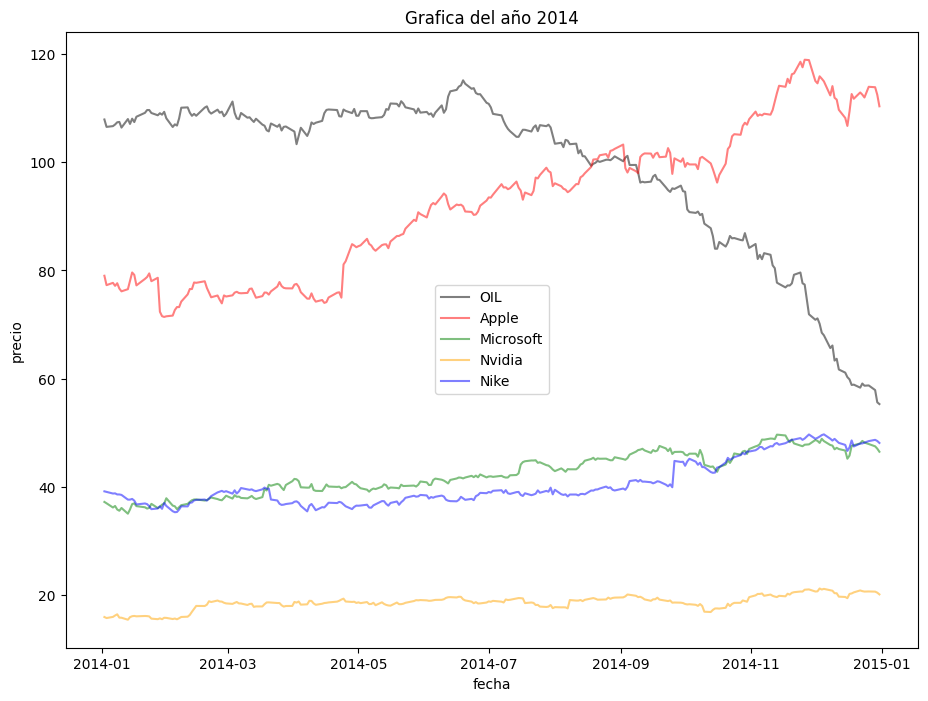

In [4]:
def visualizacion_por_año(año, datos):
    if 2014<=año<=2017:
        datos_año = datos[datos['año'] == año].sort_values('date')
    else:
        año = '2014 a 2017'
        datos_año = datos.sort_values('date')
    plt.figure(figsize=(11,8))
    plt.plot(datos_año['date'], datos_año['price_OIL'], label = 'OIL', color = 'black', alpha = .5)
    plt.plot(datos_año['date'], datos_año['close_AAPL'], label = 'Apple', color = 'red', alpha = .5)
    plt.plot(datos_año['date'], datos_año['close_MSFT'], label = 'Microsoft', color = 'green', alpha = .5)
    plt.plot(datos_año['date'], datos_año['close_NVDA'], label = 'Nvidia', color = 'orange', alpha = .5)
    plt.plot(datos_año['date'], datos_año['close_NKE'], label = 'Nike', color = 'blue', alpha = .5)
    plt.title(f'Grafica del año {año}')
    plt.xlabel('fecha')
    plt.ylabel('precio')
    plt.legend()
    plt.show()

año = 2014
visualizacion_por_año(año, df)


En el siguiente bloque se cre una funcion que dadas 2 acciones regresa la correlacion entre ellas a modo de grafica con la primera accion en el eje X y la segunda en el eje Y. Tambien se hace una regresion lineal para estimar la pendiente de la relacion entre las dos acciones, de esta forma entre mayor sea la pendeinte mayor sera la correlacion entre dichas acciones, es decir que si la accion A sube de precio es muy probable que la accion B tambien lo haga.

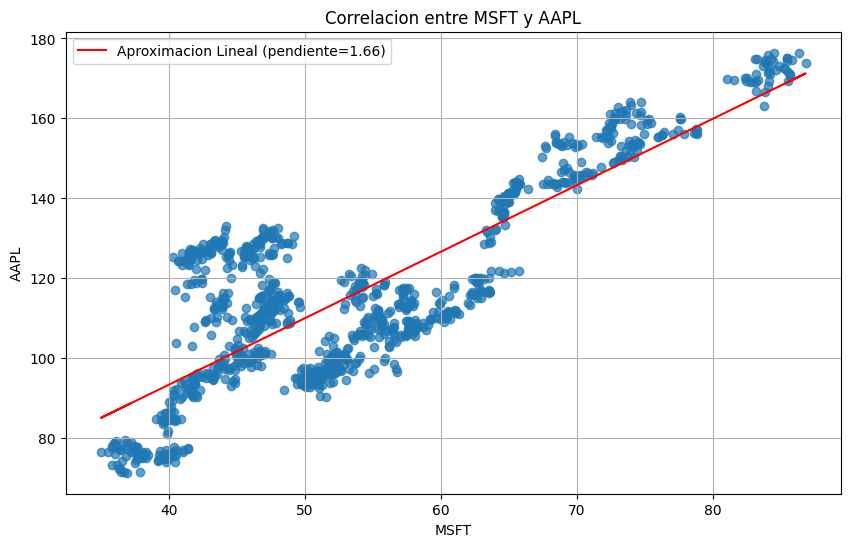

In [5]:
def correlacion_entre_dos_acciones(df, accion1, accion2):
    if (accion1 in ("AAPL", "MSFT", "NVDA", "NKE", "OIL")) & (accion2 in ("AAPL", "MSFT", "NVDA", "NKE", "OIL")):
        df = df.sort_values('date')
        if accion1 == 'OIL':
            columna1 = 'price_OIL'
        elif accion1 in ("AAPL", "MSFT", "NVDA", "NKE"):
            columna1 = 'close_' + accion1

        if accion2 == 'OIL':
            columna2 = 'price_OIL'
        elif accion2 in ("AAPL", "MSFT", "NVDA", "NKE"):
            columna2 = 'close_' + accion2

        plt.figure(figsize=(10, 6))
        plt.scatter(df[columna1], df[columna2], alpha=0.7)
        plt.title(f'Correlacion entre {accion1} y {accion2}')
        plt.xlabel(accion1)
        plt.ylabel(accion2)
       

        #Calcular la regresión lineal y graficarla
        coeficientes = np.polyfit(df[columna1], df[columna2], 1)
        pendiente, interseccion = coeficientes
        aproximacion_x = df[columna1]
        aproximacion_y = pendiente * df[columna1] + interseccion
        plt.plot(aproximacion_x, aproximacion_y, color='red', label=f'Aproximacion Lineal (pendiente={pendiente:.2f})')
 
        plt.grid(True)
        plt.legend()
        plt.show()

    else:
        print("Accion Incorrecta")

correlacion_entre_dos_acciones(df, 'MSFT', 'AAPL')

A continuacion se agrega una matriz donde se grafica la correlacion entre cada pareja de variables junto con su regresion lineal.

La función corr() nos da un valor que varía en una escala de -1 a 1, donde valores cercanos a 1 indican una correlación positiva y valores cercanos a -1 indican una correlación negativa. En otras palabras, el valor de correlación nos ofrece información sobre cómo se relacionan dos variables: si el valor es cercano a 1, hay una correlación positiva, lo que significa que si el valor de una variable sube, es probable que la otra también lo haga. Si el valor es cercano a -1, hay una correlación negativa, indicando que si el valor de una variable sube, es probable que el de la otra baje, y viceversa. En el caso de un valor cercano a 0, implica que no hay una correlación evidente entre las dos variables.

En el siguiente bloque, mediante la biblioteca Seaborn, creamos un mapa de calor para mapear la matriz de correlacion entre los precios de las acciones AAPL, MSFT, NVDA, NKE y el precio del petróleo OIL. Este gráfico nos proporciona de una forma muy grafica cómo reaccionan los precios de las acciones ante cambios en otras. De aqui podemos concluir varias aceveraciones.

1. Se observa que, Nike tiene la mayor correlacion negativa con el petrolo. Esto es de esperarse, ya que la mayoria de las fibras que se ocupan son derivados del petroleo asi que si este sube sube de precio los costos son mayores para NIKE por lo tanto la utilidad es menor y el valor de la accion baja.

2. De las 3 compañias de tecnologia la que menos relacion tiene con el petroleo es Nvidia; sin embargo, tanto Apple como Microsoft mantienen poca relacion y son poco susceptibles a los cambos de precio en el petroleo.

3. Las 3 compañias de tecnologia tienen poca relacion positiva con nike, es decir si estas suben afectan de forma positiva a nike pero no de manera relevante.

4. La corelacion positiva entre Microsoft Y NVidia, en cambio, es mucho mayor y se ve una evidente sinergia entre ambas compañias. Lo mismo sucede con Apple aunque en menor escala ya que Apple no ocpupa chips NVidia sino los propios pero al ser una empresa tecnologica impulsa a todo el mercado. 

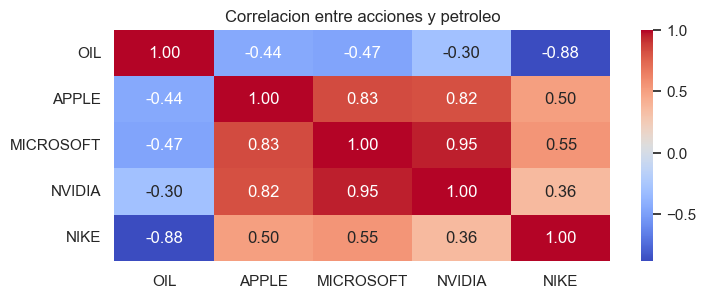

In [6]:
#Preparar datos y hacer matriz de correlacion
columnas_eliminar = ['date', 'open_AAPL', 'high_AAPL', 'low_AAPL',
       'volume_AAPL', 'open_MSFT', 'high_MSFT', 'low_MSFT',
       'volume_MSFT', 'open_NVDA', 'high_NVDA', 'low_NVDA',
       'volume_NVDA', 'open_NKE', 'high_NKE', 'low_NKE',
       'volume_NKE', 'variacion_AAPL', 'variacion_MSFT', 'variacion_NVDA',
       'variacion_NKE', 'año', 'mes']
df_correlacion = df.drop(columnas_eliminar, axis=1, inplace=False)
# Cambiar los nombres de las columnas
columnas_nuevas = ['OIL', 'APPLE', 'MICROSOFT', 'NVIDIA', 'NIKE']
df_correlacion.rename(columns=dict(zip(df_correlacion.columns, columnas_nuevas)), inplace=True)

matriz_correlacion = df_correlacion.corr()

#Crear grafica de correlacion de valors de las acciones y el petroleo
sns.set()
plt.figure(figsize=(8, 3))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")

# Mostrar el mapa de calor
plt.title('Correlacion entre acciones y petroleo')
plt.show()

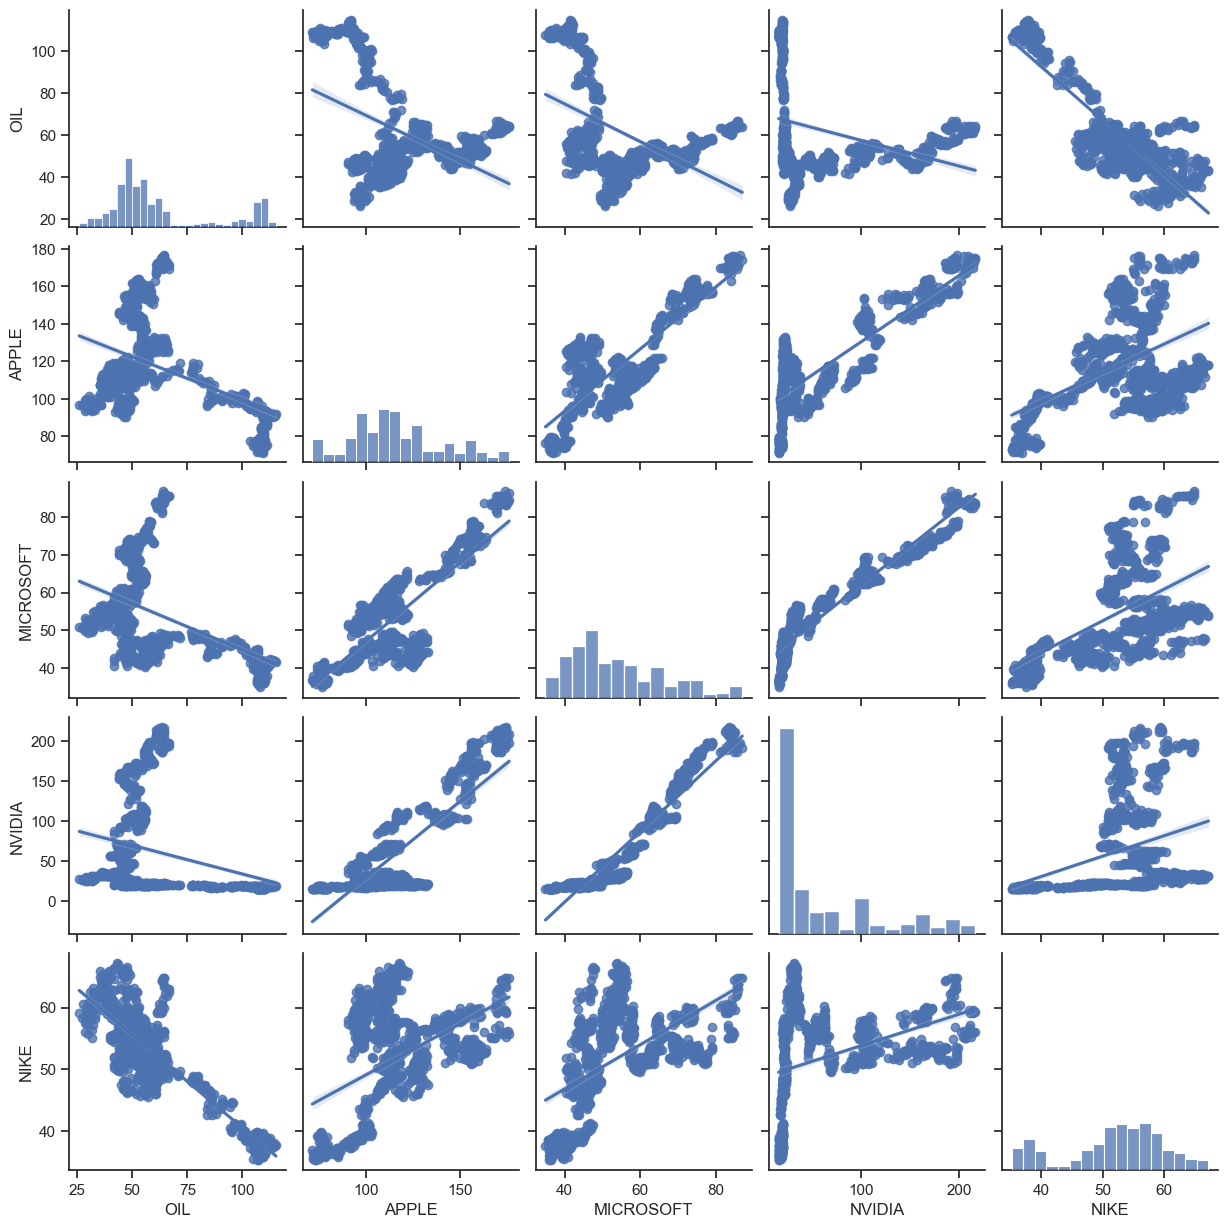

In [7]:
# Crear el pair plot
sns.set(style="ticks")
pair_plot = sns.pairplot(df_correlacion, kind="reg")

# Mostrar la gráfica
plt.show()